In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import scipy as sp
import json
import torch
torch.set_default_dtype(torch.float64)
device="cpu"
from equistore import Labels, TensorBlock, TensorMap
from utils.builder import TensorBuilder
import ase.io
from itertools import product
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine, _remove_suffix
from utils.clebsh_gordan import ClebschGordanReal
from utils.hamiltonians import hamiltonian_features
import matplotlib.pyplot as plt

from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from rascal.representations import SphericalExpansion
import copy
from utils.model_hamiltonian import *
from itertools import product
import tqdm.notebook as tqdm

In [3]:
from utils.mp_utils import * 

In [46]:
frames1 = ase.io.read("./data/random-methane-10k.extxyz",":100")
# frames2 = ase.io.read("mp_equistore/data/hamiltonian/ethanol-hamiltonian/ethanol_4500.xyz",":1")
# frames3= [ase.build.molecule('NH3')]
frames = frames1#+frames2+frames3#+frames2
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50
energies = torch.tensor([f.info['energy'] for f in frames])
energies -= energies.mean()

In [47]:
rascal_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
    
}
spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])

In [48]:
cg = ClebschGordanReal(5)

In [49]:
gij_hypers = {
    "interaction_cutoff": 3.5,
    "cutoff_smooth_width": 0.3,
    "max_radial": 4,
    "max_angular": 2,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
#     "expansion_by_species_method": "user defined",
#     "global_species": [1,6,8,7]
}    
pairs = RascalPairExpansion(gij_hypers)
gij = pairs.compute(frames)

In [50]:
gij =  acdc_standardize_keys(gij)

In [51]:
rhoii1i2_nu0 = cg_combine(gij, gij, clebsch_gordan=cg, other_keys_match=['species_center'], lcut=4)

In [52]:
rhoii1i2_nu0

TensorMap with 64 blocks
keys: ['order_nu' 'inversion_sigma' 'spherical_harmonics_l' 'species_center' 'species_neighbor_a' 'species_neighbor_b']
           2             1                    0                   1                 1                   1
           2             1                    0                   1                 1                   6
           2             1                    1                   1                 1                   1
        ...
           2             1                    4                   6                 6                   1
           2            -1                    3                   6                 6                   6
           2             1                    4                   6                 6                   6

In [53]:
rhoii1i2_nu1 =  cg_combine(rho1i, rhoii1i2_nu0, clebsch_gordan=cg, other_keys_match = ['species_center'], lcut=0, filter_sigma=[1])

In [54]:
rhoii1i2_nu1.keys

Labels([(3, 1, 0, 1, 1, 1), (3, 1, 0, 1, 1, 6), (3, 1, 0, 1, 6, 1),
        (3, 1, 0, 1, 6, 6), (3, 1, 0, 6, 1, 1), (3, 1, 0, 6, 1, 6),
        (3, 1, 0, 6, 6, 1), (3, 1, 0, 6, 6, 6)],
       dtype=[('order_nu', '<i4'), ('inversion_sigma', '<i4'), ('spherical_harmonics_l', '<i4'), ('species_center', '<i4'), ('species_neighbor_a', '<i4'), ('species_neighbor_b', '<i4')])

In [55]:
rhoii1i2_nu1.blocks(spherical_harmonics_l=0, inversion_sigma=1, species_center=1)

[TensorBlock
     samples: ['structure', 'center', 'neighbor_1', 'neighbor_2']
     component: ['spherical_harmonics_m']
     properties: ['species_neighbor_a', 'n_1_a', 'k_3', 'n_1_a_b', 'k_2_b', 'n_1_b_b', 'l_2_b', 'l_3']
     gradients: no,
 TensorBlock
     samples: ['structure', 'center', 'neighbor_1', 'neighbor_2']
     component: ['spherical_harmonics_m']
     properties: ['species_neighbor_a', 'n_1_a', 'k_3', 'n_1_a_b', 'k_2_b', 'n_1_b_b', 'l_2_b', 'l_3']
     gradients: no,
 TensorBlock
     samples: ['structure', 'center', 'neighbor_1', 'neighbor_2']
     component: ['spherical_harmonics_m']
     properties: ['species_neighbor_a', 'n_1_a', 'k_3', 'n_1_a_b', 'k_2_b', 'n_1_b_b', 'l_2_b', 'l_3']
     gradients: no,
 TensorBlock
     samples: ['structure', 'center', 'neighbor_1', 'neighbor_2']
     component: ['spherical_harmonics_m']
     properties: ['species_neighbor_a', 'n_1_a', 'k_3', 'n_1_a_b', 'k_2_b', 'n_1_b_b', 'l_2_b', 'l_3']
     gradients: no]

In [56]:
len(rhoii1i2_nu1.block(0).properties)

2688

In [57]:
cov = np.zeros((len(rhoii1i2_nu1.block(0).properties), len(rhoii1i2_nu1.block(0).properties)))
for k, b in tqdm.tqdm(rhoii1i2_nu1):
    cov += b.values.squeeze().T@b.values.squeeze()

In [58]:
eva, eve = np.linalg.eigh(cov)

In [59]:
eva = eva[::-1]
eve = eve[:, ::-1]

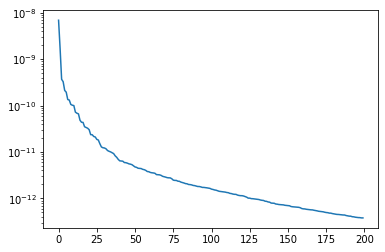

In [60]:
plt.semilogy(eva[:200])

In [61]:
def StructureMap(samples_structure, device="cpu"):
    unique_structures, unique_structures_idx = np.unique(
        samples_structure, return_index=True
    )
    new_samples = samples_structure[np.sort(unique_structures_idx)]
    # we need a list keeping track of where each atomic contribution goes
    # (e.g. if structure ids are [3,3,3,1,1,1,6,6,6] that will be stored as
    # the unique structures [3, 1, 6], structure_map will be
    # [0,0,0,1,1,1,2,2,2]
    replace_rule = dict(zip(unique_structures, range(len(unique_structures))))
    structure_map = torch.tensor(
        [replace_rule[i] for i in samples_structure],
        dtype=torch.long,
        device=device,
    )
    return structure_map, new_samples, replace_rule

def block_compress(block, compress):
    samples = (
        block.samples.view(dtype=np.int32).reshape(-1, len(block.samples.names)).copy()
    )
    samples = Labels(block.samples.names, samples)

    new_block = TensorBlock(
        values=torch.tensor(block.values@compress),
        samples=samples,
        components=block.components,
        properties=Labels(["pca"], np.arange(0, compress.shape[1], dtype=np.int32)[:,np.newaxis]),
    )

    for parameter in block.gradients_list():
        gradient = block.gradient(parameter)

        gradient_samples = (
            gradient.samples.view(dtype=np.int32)
            .reshape(-1, len(gradient.samples.names))
            .copy()
        )
        if gradient.samples.names == ("sample", "structure", "atom"):
            gradient_samples[:, 1] = structure_i
        gradient_samples = Labels(gradient.samples.names, gradient_samples)

        new_block.add_gradient(
            parameter=parameter, # TODO: compress also the gradient
            data=torch.tensor(gradient.data),
            samples=gradient_samples,
            components=gradient.components,
        )

    return new_block


def move_and_compress(tensor_map, compress):
    blocks = []
    for _, block in tensor_map:
        blocks.append(block_compress(block, compress))

    return TensorMap(tensor_map.keys, blocks)


In [62]:
class NNModel(torch.nn.Module):
    def __init__(self, layer_size=100):
        super().__init__()

        self.nn = None
        self.layer_size = layer_size

    def initialize_model_weights(self, block, seed):
        if seed is not None:
            torch.manual_seed(seed)

        X = block.values

        # initialize nn with zero weights ??
        def init_zero_weights(m):
            if isinstance(m, torch.nn.Linear):
                m.weight.data.fill_(0)
                m.bias.data.fill_(0)

        self.nn = torch.nn.Sequential(
            torch.nn.Linear(X.shape[-1], self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, self.layer_size),
            torch.nn.Tanh(),
            torch.nn.Linear(self.layer_size, 1),
        )

    def forward(self, block):
        if self.nn is None:
            raise Exception("call initialize_weights first")

        tensor = block.values.squeeze()

        structure_map, new_samples, _ = StructureMap(
            block.samples["structure"], tensor.device
        )
        
        nn_per_triple = self.nn(tensor)
        nn_per_structure = torch.zeros((len(new_samples), 1), device=tensor.device)
        nn_per_structure.index_add_(0, structure_map, nn_per_triple)
        energies = nn_per_structure
        return energies

In [63]:
class NNTriple(torch.nn.ModuleDict):
    
    def __init__(self, species, layer_size=100):
        super().__init__()

        for a,b,c in product(species, species, species):
            self[str((a,b,c))] = NNModel(layer_size)            
    
    def initialize_model_weights(self, descriptor, seed):
        for (_,_,_,a,b,c), block in descriptor:
            self[str((a,b,c))].initialize_model_weights(block, seed)
            
    def forward(self, descriptor):
        first = True
        for (_,_,_,a,b,c), block in descriptor:
            if first:
                energy = self[str((a,b,c))].forward(block)
            else:
                energy += self[str((a,b,c))].forward(block)
        return energy
        

In [64]:
rhoii1i2_nu1_torch = move_and_compress(rhoii1i2_nu1, 1e7*eve[:,:200]) # also makes these sizable

In [65]:
mymodel = NNTriple([1,6])

In [66]:
mymodel.initialize_model_weights(rhoii1i2_nu1_torch, seed=12345)

In [67]:
mymodel(rhoii1i2_nu1_torch)

tensor([[-0.0504],
        [-0.0458],
        [-0.1045],
        [-0.0979],
        [-0.1063],
        [-0.1254],
        [-0.0271],
        [-0.0812],
        [-0.0844],
        [-0.0849],
        [-0.0923],
        [-0.0785],
        [-0.1447],
        [-0.1157],
        [-0.0666],
        [-0.0744],
        [-0.0510],
        [-0.0382],
        [-0.0293],
        [-0.1865],
        [-0.0840],
        [-0.0461],
        [-0.1230],
        [-0.0953],
        [-0.0969],
        [-0.0830],
        [-0.0534],
        [-0.1549],
        [-0.0801],
        [-0.0938],
        [-0.0752],
        [-0.1210],
        [-0.1193],
        [-0.0434],
        [-0.0212],
        [-0.0747],
        [-0.0773],
        [-0.1212],
        [-0.0646],
        [-0.1263],
        [-0.0991],
        [-0.0955],
        [-0.0848],
        [-0.0681],
        [-0.0551],
        [-0.0626],
        [-0.0627],
        [-0.0574],
        [-0.0452],
        [-0.0977],
        [-0.0596],
        [-0.0796],
        [-0.

In [68]:
optimizer = torch.optim.LBFGS(
        mymodel.parameters(),
        lr=0.05,
        line_search_fn="strong_wolfe",
        history_size=128,
    )

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten()) ** 2)

In [ ]:
n_epochs=100
for epoch in range(0, n_epochs):
    print("Beginning epoch", epoch)
    
    def single_step():
        # global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        loss = torch.zeros(size=(1,), device=device)
        
        predicted = mymodel(rhoii1i2_nu1_torch)
        loss += loss_mse(predicted, energies)
        
        loss.backward(retain_graph=False)
        return loss

    loss = optimizer.step(single_step)
    print("Energy train RMSE", np.sqrt(loss.detach().numpy().flatten()[0]) )

Beginning epoch 0
Energy train RMSE 0.14760833917873328
Beginning epoch 1
Energy train RMSE 0.14586152279080275
Beginning epoch 2
Energy train RMSE 0.14278525341132445
Beginning epoch 3
Energy train RMSE 0.1404039764385819
Beginning epoch 4
Energy train RMSE 0.13825263629737045
Beginning epoch 5
Energy train RMSE 0.13710983430163953
Beginning epoch 6
Energy train RMSE 0.13565360933388232
Beginning epoch 7
Energy train RMSE 0.13355332120696248
Beginning epoch 8
Energy train RMSE 0.1290953634482688
Beginning epoch 9
Energy train RMSE 0.12702755494421375
Beginning epoch 10
Energy train RMSE 0.12556865236888648
Beginning epoch 11
Energy train RMSE 0.12416395124393353
Beginning epoch 12
Energy train RMSE 0.12215431014262759
Beginning epoch 13
Energy train RMSE 0.12045824655163127
Beginning epoch 14
Energy train RMSE 0.1187209601274434
Beginning epoch 15
Energy train RMSE 0.11622253763955703
Beginning epoch 16
Energy train RMSE 0.115111688448714
Beginning epoch 17
Energy train RMSE 0.1140958